# Machine learning for genetic data

In [1]:
%pylab inline 
# imports matplotlib as plt and numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 16}) # font size for text on plots

## Data description

* `data/athaliana_small.X.txt` is the design matrix. As many rows as samples, as many columns as SNPs
* the SNPs are given (in order) in `data/athaliana_small.snps.txt`. 
* the samples are given (in order) in `data/athaliana.samples.txt`.

* the transformed phenotypes are given in `data/athaliana.4W.pheno` and `data/athaliana.2W.pheno`. The first column is the sample's ID, and the second the phenotype.

* `data/athaliana.candidates.txt` contains a list of _A. thaliana_ genes known or strongly suspected to be associated with flowering times.

* the feature network is in `data/athaliana_small.W.txt`. It has been saved as 3 arrays, corresponding to the row, col, and data attributes of a [scipy.sparse coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html).

## Loading the data
We will start by working without the feature network, on the 2W phenotype.

In [3]:
# Load the SNP names
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names))

9419


In [4]:
# Load the design matrix -- this can take time!
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype = 'int') # values are integers

In [5]:
X.shape

(1307, 9419)

In [6]:
p = X.shape[1]

We have 1307 samples and 9 419 SNPs.

The 2W phenotype is not available for all samples. 

#### Load the sample names

In [7]:
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype = int)) # values are integers
print(len(samples))
print(samples[:10])

1307
[9381, 9380, 9378, 9371, 9367, 9363, 9356, 9355, 9354, 9353]


### Load the 2W phenotype data

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header = None, # columns have no header
                 delim_whitespace = True) # columns are separated by white space

# Create vector of sample IDs
samples_with_phenotype = list(df[0])
print(len(samples_with_phenotype), "samples have a phenotype")

# Create vector of phenotypes
y_2W = np.array(df[1])

152 samples have a phenotype


In [10]:
# Restrict X to the samples with a 2W phenotype, in correct order
# X_2W[i] = X[samples.index(samples_with_phenotype[i])]
X_2W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype]), :]
print(X_2W.shape)

(152, 9419)


### Load the list of candidate genes

In [11]:
with open('data/athaliana.candidates.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

### Load the snps to gene mapping

In [12]:
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/athaliana.snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

### Split the data in a train and test set

We will set aside a test set, containing 20% of our samples, on which to evaluate the quality of our predictive models.

In [13]:
from sklearn import model_selection

In [14]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W, test_size = 0.2, random_state = 17)
print(X_2W_tr.shape, X_2W_te.shape)

(121, 9419) (31, 9419)


## Elastic net

One solution to make the lasso more stable is to use a combination of the l1 and l2 regularizations.

We are now minimizing the loss + a linear combination of an l1-norm and an l2-norm over the regression weights. This imposes sparsity, but encourages correlated features to be selected together, where the lasso would tend to pick only one (at random) of a group of correlated features.

The elastic net is implemented in scikit-learn's [linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

### Regularization path

In [15]:
from sklearn import linear_model

In [16]:
eps = 3e-1

In [17]:
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X_2W_tr[:, :], y_2W_tr, eps = eps, fit_intercept = True)

In [18]:
alphas_enet, coefs_enet, _ = linear_model.enet_path(
    X_2W_tr[:, :], y_2W_tr, eps = eps, l1_ratio = 0.95, fit_intercept = True)

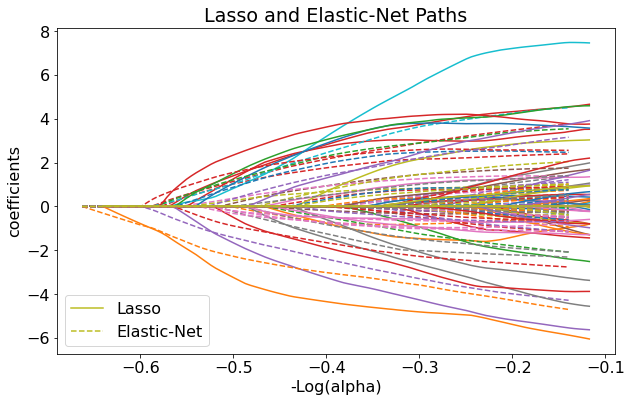

In [19]:
from itertools import cycle
import matplotlib.colors as mcolors
colors = cycle(list(mcolors.TABLEAU_COLORS.keys()))
figure(figsize = (10, 6))
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c = c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle = '--', c = c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')
plt.show()

__Q: Compared to the lasso, what is the effect of the elastic-net on the coefficients?__

__A:__ The elastic-net induces more shrinkage than the lasso. More precisely, by selecting groups of correlated variables together, the elastic-net tends to shrink each of them more.

### Fit lastic-net

In [20]:
# Parameters grid
alphas = np.logspace(-4., 1., num = 15)
ratios = np.linspace(0.5, 1., num = 15)

__Q: Define the elastic net model (call it `model_l1l2`) using the functions `ElasticNet` and `GridSearchCV`.__

In [21]:
# Answer:
enet = linear_model.ElasticNet(fit_intercept = True, max_iter = 6000)
model_l1l2 = model_selection.GridSearchCV(enet, 
                                        param_grid = {'alpha': alphas, 'l1_ratio': ratios}, 
                                        scoring = 'explained_variance')
model_l1l2.fit(X_2W_tr, y_2W_tr)

/shared/software/miniconda/envs/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.18740496023208, tolerance: 4.037147787395833
  positive)
/shared/software/miniconda/envs/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.877920142284204, tolerance: 5.813806200206185
  positive)
/shared/software/miniconda/envs/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0967815158641425, tolerance: 5.330533580824742
  positive)
/shared/software/miniconda/envs/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532

GridSearchCV(estimator=ElasticNet(max_iter=6000),
             param_grid={'alpha': array([1.00000000e-04, 2.27584593e-04, 5.17947468e-04, 1.17876863e-03,
       2.68269580e-03, 6.10540230e-03, 1.38949549e-02, 3.16227766e-02,
       7.19685673e-02, 1.63789371e-01, 3.72759372e-01, 8.48342898e-01,
       1.93069773e+00, 4.39397056e+00, 1.00000000e+01]),
                         'l1_ratio': array([0.5       , 0.53571429, 0.57142857, 0.60714286, 0.64285714,
       0.67857143, 0.71428571, 0.75      , 0.78571429, 0.82142857,
       0.85714286, 0.89285714, 0.92857143, 0.96428571, 1.        ])},
             scoring='explained_variance')

In [22]:
# Option 2: using function ElasticNetCV
model_l1l2_2 = linear_model.ElasticNetCV(l1_ratio = ratios, fit_intercept = True, max_iter = 6000).fit(X_2W_tr, y_2W_tr)

In [23]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1l2.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("elastic net regression weight")
plt.xlim([0, p])

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

<Figure size 432x288 with 0 Axes>

In [ ]:
print("%d SNPs selected," % \
    np.nonzero(model_l1l2.coef_)[0].shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in np.nonzero(model_l1l2.coef_)[0]:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1

print("of which %d are in %d candidate genes" % (num_snps_in_candidate_genes, 
                                                          len(candidate_genes_hit)))

__Q: How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

__A:__ 441 SNPs are selected. This is more than twice as much as the lasso, which highlights that the elastic-net will favor shrinking correlated variables instead of selected out all but one (this is called the *grouping effect*).

### Predictive power 

In [3]:
from sklearn import metrics

In [ ]:
y_2W_l1l2_pred = model_l1l2.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1l2.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1l2_pred)))

In [ ]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_te, y_2W_l1l2_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.ylim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.axline(xy1 = [0, 0], slope = 1, c = "black")

## Multi-task feature selection

1) Repeat the previous analysis for the 4W phenotype. It is very similar to the 2W phenotype, except that the seeds have been vernelized for 4 weeks. 

2) It is not unreasonable to expect the genomic regions driving both those phenotypes to be (almost) the same. Use the multi-task version of the Lasso, ENet, or ncLasso algorithms to analyzed both phenotypes simultaneously.

Use [sklearn.linear_model.MultiTaskLasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso) + [User Guide](http://scikit-learn.org/stable/auto_examples/linear_model/plot_multi_task_lasso_support.html)

3) __Q: Is it the same "multi-task" setting as the one in the lecture? What is the difference?__

__A:__ In the "real" multi-task setting (Obozinski et al., *Multi-task feature selection*, 2006), there are one design matrix and one output for each task. Here, however, the design matrix is the same for both tasks: we use the same genomic data -- the "individuals" are the same --, and only the phenotypes differs.

Consequently, this setting is more restrictive than Obozinski's multi-task lasso.

### Load 4W and 2W phenotypes

In [ ]:
X_2W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype]), :]

In [ ]:
df_2W = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header = None, # columns have no header
                 delim_whitespace = True) # columns are separated by white space

# Create vector of sample IDs
samples_with_phenotype_2W = list(df[0])
print(len(samples_with_phenotype_2W), "samples have a phenotype")

# Create vector of phenotypes
y_2W = np.array(df_2W[1])

In [ ]:
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype = 'int') # values are integers

In [ ]:
df_4W = pd.read_csv('data/athaliana.4W.pheno', # file name
                 header = None, # columns have no header
                 delim_whitespace = True) # columns are separated by white space

# Create vector of sample IDs
samples_with_phenotype_4W = list(df_4W[0])
print(len(samples_with_phenotype_4W), "samples have a 4W phenotype")

# Create vector of phenotypes
y_4W = np.array(df_4W[1])

In [ ]:
X_4W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype_4W]), :]

In [ ]:
X_4W_tr, X_4W_te, y_4W_tr, y_4W_te = \
    model_selection.train_test_split(X_4W, y_4W, test_size = 0.2, random_state = 17)
print(X_4W_tr.shape, X_4W_te.shape)

### Preliminary analysis
__Q: Why would we expect the 2W and 4W phenotypes to share many explanatory SNPs? How could you verify this using Manhattan plots?__

In [ ]:
# Answer:
import statsmodels.api as sm
## Compute p-values for both 2W and 4W
pvalues_2W = []
pvalues_4W = []
for snp_idx in range(p):
    ## 2W
    X_snp_2W = sm.add_constant(X_2W_tr[:, snp_idx])
    est_2W = sm.regression.linear_model.OLS(y_2W_tr, X_snp_2W).fit()
    pvalues_2W.append(est_2W.pvalues[1])
    ## 4W
    X_snp_4W = sm.add_constant(X_4W_tr[:, snp_idx])
    est_4W = sm.regression.linear_model.OLS(y_4W_tr, X_snp_4W).fit()
    pvalues_4W.append(est_4W.pvalues[1])
pvalues_2W = np.array(pvalues_2W)
pvalues_4W = np.array(pvalues_4W)

## Overlay both Manhattan plots 
figure(figsize = (15, 4))

plt.scatter(range(p), -np.log10(pvalues_2W), alpha = 0.6, s = 5)
t = -np.log10(0.05 / p)
plt.plot([0, p], [t, t], c = "black")
plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

plt.scatter(range(p), np.log10(pvalues_4W), alpha = 0.6, s = 5)
plt.plot([0, p], [-t, -t], c = "black")

plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

Another possible visualization is to plot both pvalues ax xy-coordinates:

In [ ]:
figure(figsize = (5, 5))
plt.scatter(-np.log10(pvalues_2W), -np.log10(pvalues_4W))
plt.xlabel('2W'); plt.ylabel('4W')

Most SNPs are in the upper-low left corner (low p-values for both phenotypes). But there is a number of SNPs with both large 4W-pvalues and 2W-pvalues, which shows that the two pvalues are correlated. Moreover, there are no SNPs with a high pvalue for one phenotype and a small pvalue for the other.

__Q: What conclusion can you draw? Do the 2W and 4W phenotypes seem to be linked to the same genome loci?__

__A:__ Comparison of the two pvalues indicates that the two phenotypes must be explained but the same set of SNPs (or at least, there is a large intersection between the two sets). This justifies using a multi-task setting.

### Define design matrix

Sample with *both* 2W and 4W phenotypes.

In [ ]:
samples_with_phenotype_both = list(set(samples_with_phenotype_2W).intersection(samples_with_phenotype_4W))
print(len(samples_with_phenotype_both), "samples have both phenotypes")

In [ ]:
X_both = X[np.array([samples.index(sample_id) for sample_id in samples_with_phenotype_both]), :]
del X # You can delete X now if you want, to free space

Filter, order, and merge the two phenotype data frames

In [ ]:
## Filter out the samples that do not have both phenotypes
df_4W_filtered = df_4W[df_4W[0].isin(samples_with_phenotype_both)]
df_2W_filtered = df_2W[df_2W[0].isin(samples_with_phenotype_both)]
## Set sample names as the DataFrame index name
df_2W_filtered.index = list(df_2W_filtered[0])
df_4W_filtered.index = list(df_4W_filtered[0])
## Reorder both datasets so as to have the phenotypes in the same order
df_2W_ordered = df_2W_filtered.reindex(samples_with_phenotype_both)
df_4W_ordered = df_4W_filtered.reindex(samples_with_phenotype_both)
## Define the phenotype matrix
y_both = np.array([df_2W_ordered[1], df_4W_ordered[1]]).T

Split in train and test sets

In [ ]:
X_both_tr, X_both_te, y_both_tr, y_both_te = \
    model_selection.train_test_split(X_both, y_both, test_size = 0.2, random_state = 19)

In [ ]:
print(y_both.shape, y_both_tr.shape, y_both_te.shape)
print(X_both.shape, X_both_tr.shape, X_both_te.shape)

### Run Multi-task lasso

In [ ]:
from sklearn import linear_model, metrics

__Q:__ Run MultiTaskLasso (and call the object `model_mt_l1`).

In [1]:
# Answer: 
mt_l1 = linear_model.MultiTaskLasso(fit_intercept = True, max_iter = 6000)
alphas = np.logspace(-4., 2., num = 20)
model_mt_l1 = model_selection.GridSearchCV(mt_l1,
                                          param_grid = {'alpha': alphas},
                                          scoring = 'explained_variance').fit(X_both_tr, y_both_tr)

NameError: name 'np' is not defined

In [ ]:
metrics.explained_variance_score(y_both_te, model_mt_l1.best_estimator_.predict(X_both_te))

In [ ]:
model_mt_l1_2 = linear_model.MultiTaskLassoCV(fit_intercept = True, max_iter = 6000, 
                                              cv = 5, random_state = 18).fit(X_both_tr, y_both_tr)

In [ ]:
metrics.explained_variance_score(y_both_te, model_mt_l1_2.predict(X_both_te))

In [ ]:
plt.figure(figsize = (8, 5))
#plt.spy(ml_lasso_cv.best_estimator_.coef_)
plt.scatter(range(p), model_mt_l1.best_estimator_.coef_[0, :])
plt.scatter(range(p), model_mt_l1.best_estimator_.coef_[1, :])

### Predictive power

In [ ]:
from sklearn import metrics

In [ ]:
y_both_l1_pred = model_mt_l1.best_estimator_.predict(X_both_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_mt_l1.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_both_te, y_both_l1_pred)))

### Run Multi-task elastic-net
See the (https://scikit-learn.org/stable/modules/linear_model.html#multi-task-elastic-net)[user guide] and (API)[https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskElasticNet.html#sklearn.linear_model.MultiTaskElasticNet].

__Q: Do the same as before, but with (multi-task) elastic net instead!__

In [ ]:
#Answer: 
mt_l1l2 = linear_model.MultiTaskElasticNet(fit_intercept = True, max_iter = 6000)
alphas = np.logspace(-4., 2., num = 20)
l1_ratios = np.linspace(0.5, 0.99, num = 10)
model_mt_l1l2 = model_selection.GridSearchCV(mt_l1l2,
                                          param_grid = {'alpha': alphas, 'l1_ratio': l1_ratios},
                                          scoring = 'explained_variance').fit(X_both_tr, y_both_tr)

## Network-constrained lasso

### Load the network

In [ ]:
from scipy import sparse

In [ ]:
w_saved = np.loadtxt('data/athaliana_small.W.txt') # adjacency matrix is in coordinate (or triplet) format

In [ ]:
# Create adjacency matrix in scipy.sparse.coo_matrix format
W = sparse.coo_matrix((w_saved[2, :], (np.array(w_saved[0, :], dtype = int), 
                                       np.array(w_saved[1, :], dtype = int))),
                      shape = (p, p))

### Create the transposed incidence matrix

__Q: The incidence matrix of a graph? What is it again? You may refer to Wikipedia, or the paper `Network-constrained regularization and variable selection
for analysis of genomic data`__

__A:__ The incidence matrix $S$ is a matrix of dimensions (#nodes, #edges) such that $S S^T = L$, where $L$ is the Laplacian of the graph. Note that when there are many edges, the dimensions of $S$ can far exceed that of $L$!

Now let's create it.

In [ ]:
degrees = np.zeros((p, ))
for vertex in W.row:
    degrees[vertex] += 2

We will define `tim`, the "transpose incidence matrix"

In [ ]:
row_ix = 0
tim = sparse.lil_matrix((w_saved[0].shape[0] // 2, p))
for ix, edge in enumerate(w_saved[2, :]):
    if w_saved[0, ix] < w_saved[1, ix]: # counts each edge-vertex link only once
        tim[row_ix, w_saved[0, ix]] = np.sqrt(edge / degrees[W.row[ix]])
        tim[row_ix, w_saved[1, ix]] = -np.sqrt(edge / degrees[W.row[ix]])
        row_ix += 1

Let us verify that tim is the transposed incidence matrix

In [ ]:
laplacian1 = (np.transpose(tim) @ tim).toarray()

In [ ]:
laplacian2 = np.diag(np.ones(p) - W.toarray().sum(axis = 0) / degrees) - \
W.toarray() / np.sqrt(np.outer(degrees, degrees))

In [ ]:
np.allclose(laplacian1, laplacian2)

In [ ]:
np.linalg.norm(np.where(np.abs(laplacian1 - laplacian2) > 1e-8)[0], ord = 0) / np.prod(laplacian1.shape)

Conclusion: the computation of `tim` has errors in 0.7% of the cases. It should be fixed, but no time now! It should have a limited impact on the result, because only a small proportion of edges are miscomputed. Still, it's bad practice.

### Define ncLasso class

In [ ]:
from sklearn import base, linear_model

The network-constrained lasso is just a disguised lasso! By defining a modified design matrix X_new and output vector y_new, we can solve the network-constrained lasso problem using the usual `linear_model.Lasso` function.

__Q: Go on the [paper introducing network-constrained lasso](https://academic.oup.com/bioinformatics/article/24/9/1175/206444) and fill in the missing line using Lemma 1.__

__A:__ The missing line has been filled: the new design matrix $X_new$ is defined in the paper as $X_{new}^T = (1 + \lambda_2)^{-1/2} (X^T | \sqrt{\lambda_2}S)^T$.
This trick is similar to the one used to convert to elastic-net problem as a lasso problem.

Note that this new design matrix is war larger than the original one: using sparse matrices is compulsory, as well as using functions that support use of sparse matrices.

In [ ]:
class ncLasso(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, transposed_incidence = None, lambda1 = 1.0, lambda2 = 1.0):
        self.transposed_incidence = transposed_incidence # sparse matrix
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def fit(self, X, y, max_iter = 1000):       
        alpha = self.lambda1 / (np.sqrt(self.lambda2 + 1.))
        self.lasso = linear_model.Lasso(fit_intercept = True, 
                                        alpha = alpha, max_iter = max_iter)
        y_new = np.hstack((y, np.zeros((self.transposed_incidence.shape[0], ))))
        X_new = 1 / np.sqrt(self.lambda2 + 1) * sparse.vstack(
            (X, np.sqrt(self.lambda2) * self.transposed_incidence) ## Missing line
        )
        self.lasso.fit(X_new, y_new)
        self.coef_ = self.lasso.coef_[:X.shape[1]] / np.sqrt(self.lambda2 + 1)
        return self
        
        
    def predict(self, X, y = None):
        return self.lasso.predict(X)
    
    
    def score(self, X, y = None):
        return self.lasso.score(X, y)                                        

### Run network-constrained lasso

In [ ]:
model_nclasso = ncLasso(tim, 0.00005, 0.00001)

import time
start = time.time()
## DO NOT RUN (takes two hours to run)
# model_nclasso.fit(X_2W_tr, y_2W_tr, max_iter = 2000)
## END DO NOT RUN
end = time.time()
#print(end - start)

In [ ]:
import pickle
## DO NOT RUN
#with open('model_nclasso.obj', 'wb') as f:
#    pickle.dump(model_nclasso, f, pickle.HIGHEST_PROTOCOL)
## END DO NOT RUN

with open('model_nclasso.obj', 'rb') as f:
    model_nclasso = pickle.load(f)

In [ ]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_nclasso.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("elastic net regression weight")
plt.xlim([0, p])

In [ ]:
print("%d SNPs selected," % \
    np.nonzero(model_nclasso.coef_)[0].shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in np.nonzero(model_nclasso.coef_)[0]:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1

print("%d SNPs are in %d candidate genes" % (num_snps_in_candidate_genes, 
                                                          len(candidate_genes_hit)))

In [ ]:
y_ncl1_pred = model_nclasso.predict(X_2W_te)
print(metrics.explained_variance_score(y_2W_te, y_ncl1_pred))

### Run ncLasso with cross-validation

Define Hyperparameters

In [ ]:
import numpy as np
l1 = np.logspace(-6., -3., num = 6)
l2 = np.logspace(-6., -3., num = 6)

In [ ]:
nclasso = ncLasso(tim, 0.001, 0.001)

In [ ]:
model_ncl1 = model_selection.GridSearchCV(nclasso, param_grid = {'lambda1': l1,
                                                                 'lambda2': l2},
                                   scoring = 'explained_variance')

In [ ]:
### This takes too much time to run!
#model_ncl1.fit(X_2W_tr, y_2W_tr)

In [ ]:
#plt.figure(figsize = (6, 4))
#plt.scatter(range(p), # x = SNP position
#            model_ncl1.best_estimator_.coef_)  # y = regression weights

#plt.xlabel("SNP")
#plt.ylabel("elastic net regression weight")
#plt.xlim([0, p])

If you want to use SConES/sfan, see [github/chagaz/sfan](https://github.com/chagaz/sfan). The StructuredSparsity notebook can help.

## Going further
You can also used methods developped specifically for SNP detections! 

For instance SConES (Azencott et al 2013) has a publicly available implementation as an R package (https://github.com/hclimente/martini) or in python (https://github.com/chagaz/sfan).